,RAKE,YAKE,TXTR,KBRT,MPTE
self_top1,0.72,0.90,0.13,0.89,0.89
soft,0.30,0.63,0.08,0.59,0.03
hard,0.03,0.09,0.03,0.09,0.00
avg,0.12,0.32,0.04,0.26,0.01


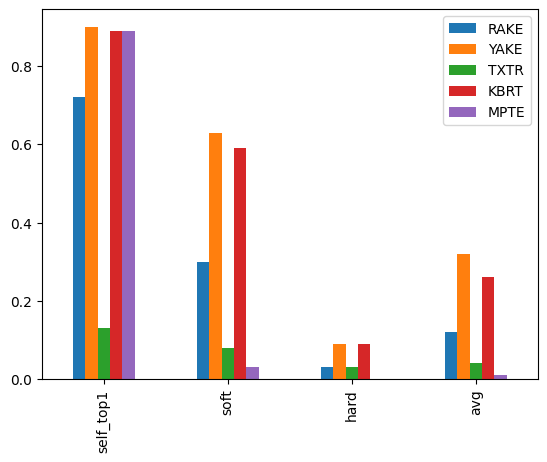

In [17]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


BASE_PATH = Path("data") / "eval"

with open(BASE_PATH / "eval.json") as file:
    data = json.load(file)
for k, v in data.items():
    del v["all_docs"]
data = pd.DataFrame(data)
# plt.legend()
# plt.hist(data)

data.plot.bar()
data